In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load the Data

In [2]:
df = pd.read_csv('HIV_df.csv')
df.head()

,AMAT_fac,HIVincidence,MH_fac,Med_AMAT_fac,Med_MH_fac,Med_SA_fac,Med_SMAT_fac,Med_TMAT_fac,Population,SA_fac,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
0,0.0,10.9,1.0,0.0,1.0,2.0,0.0,0.0,55035.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,8.7,4.0,0.0,3.0,1.0,0.0,0.0,203690.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,26270.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,22561.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,10.4,1.0,0.0,1.0,1.0,0.0,0.0,57676.0,1.0,...,0,0,0,0,0,0,0,0,0,0


## Discard one bad outlier

In [3]:
df = df[df['HIVincidence']!=df['HIVincidence'].max()]


## Separate into X and y


In [4]:
try:
    y = df.pop('HIVincidence')
    X = df.values
except:
    pass


## How many counties have non-zero incidence?

## ~25%

In [5]:
(y>0).mean()

0.25408719346049047

## Scale all Features

In [6]:
from sklearn.preprocessing import StandardScaler as SS
X = SS().fit_transform(X)

## Train/Test Split

In [7]:
from sklearn.model_selection import train_test_split as TTS
X_train, X_test, y_train, y_test = TTS(X,y, random_state = 2)

## Make a very simple model to predict `Zero` or `Non-Zero` HIV Incidence

In [8]:
from sklearn.linear_model import LogisticRegression as LR
model = LR(max_iter = 1000).fit(X_train,y_train>0)


## Score the Model. 

In [9]:
model.score(X_train, y_train>0), model.score(X_test, y_test>0) 

(0.9168937329700273, 0.9155313351498637)

## 90% Accuracy is a reasonable starting point for such a simple model.
 
## Now we'll look at only the portion of the data with non-zero HIV Incidence and make a regression model

In [10]:
HIV_X = X[y>0]
HIV_y = y[y>0]

In [11]:
HIV_X.shape

(746, 81)

In [12]:
(HIV_X_train, 
 HIV_X_test, 
 HIV_y_train, 
 HIV_y_test) = TTS(HIV_X,HIV_y, random_state=2)

## Fit a bunch of different Models with various hyperparameters

In [13]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import mean_squared_error as mse

n= 30

grid = GridSearchCV(ElasticNet(max_iter=10000, tol = .0005), 
                    {'alpha':np.logspace(-3,3,n),
                     'l1_ratio': np.linspace(.01,1, n)},
                   return_train_score = True,
                   n_jobs = -1)

grid.fit(HIV_X, HIV_y)

GridSearchCV(estimator=ElasticNet(max_iter=10000, tol=0.0005), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-03, 1.61026203e-03, 2.59294380e-03, 4.17531894e-03,
       6.72335754e-03, 1.08263673e-02, 1.74332882e-02, 2.80721620e-02,
       4.52035366e-02, 7.27895384e-02, 1.17210230e-01, 1.88739182e-01,
       3.03919538e-01, 4.89390092e-01, 7.88046282e-01, 1.26896100e+00,
       2.04335972e+...
                         'l1_ratio': array([0.01      , 0.04413793, 0.07827586, 0.11241379, 0.14655172,
       0.18068966, 0.21482759, 0.24896552, 0.28310345, 0.31724138,
       0.35137931, 0.38551724, 0.41965517, 0.4537931 , 0.48793103,
       0.52206897, 0.5562069 , 0.59034483, 0.62448276, 0.65862069,
       0.69275862, 0.72689655, 0.76103448, 0.79517241, 0.82931034,
       0.86344828, 0.89758621, 0.93172414, 0.96586207, 1.        ])},
             return_train_score=True)

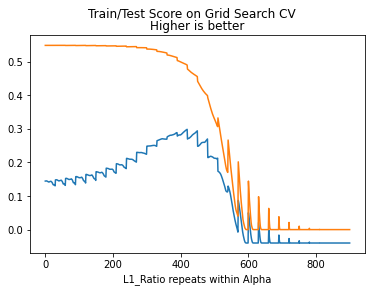

In [14]:
plt.plot(grid.cv_results_['mean_test_score'])
plt.plot(grid.cv_results_['mean_train_score'])
plt.suptitle("Train/Test Score on Grid Search CV")  
plt.title("Higher is better")
plt.xlabel("L1_Ratio repeats within Alpha");

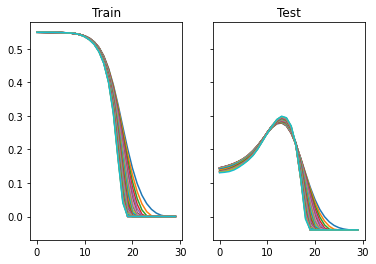

In [15]:
scores = [grid.cv_results_['mean_train_score'], 
          grid.cv_results_['mean_test_score']]

fig, axs = plt.subplots(1,2, sharey=True)
[ax.plot(score.reshape(n,-1)) for ax, score in zip(axs, scores)]
[ax.set_title(title) for ax, title in zip(axs, ['Train', 'Test'])];


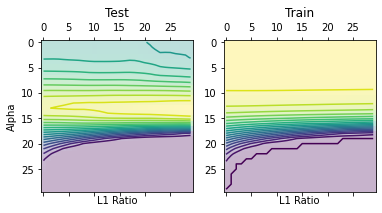

In [16]:
fig, axs = plt.subplots(1,2)
axs[0].matshow(grid.cv_results_['mean_test_score'].reshape(n,-1), alpha = .3)
axs[1].matshow(grid.cv_results_['mean_train_score'].reshape(n,-1), alpha = .3)
axs[0].contour(grid.cv_results_['mean_test_score'].reshape(n,-1), levels=20)
axs[1].contour(grid.cv_results_['mean_train_score'].reshape(n,-1), levels=20)
axs[0].set_title("Test")
axs[1].set_title("Train")
axs[0].set_ylabel('Alpha')
[ax.set_xlabel('L1 Ratio') for ax in axs];   

In [17]:
best = grid.best_estimator_
best.fit(X_train, y_train)

ElasticNet(alpha=0.4893900918477494, l1_ratio=1.0, max_iter=10000, tol=0.0005)

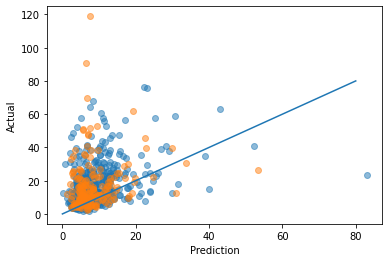

In [18]:
plt.scatter(best.predict(HIV_X_train), HIV_y_train, label = 'Train', alpha = .5)
plt.scatter(best.predict(HIV_X_test), HIV_y_test, label = 'Test', alpha = .5)
plt.plot([0,80],[0,80])
plt.xlabel('Prediction')
plt.ylabel('Actual');

## The features that made it into the final model

In [19]:
print('\n'.join(df.columns[best.coef_ !=0]))

Med_SA_fac
drugdeathrate
drugdeathrate_est
partD30dayrxrate
pctunins
bup_phys
drugdep
pctunmetneed
%msm12month
unemployment_rate
poverty_rate
household_income
DC
FL
GA
LA
NC
NJ
SC
TX
VA


## The features that were excluded from the final model

In [20]:
print('\n'.join(df.columns[best.coef_ ==0]))

AMAT_fac
MH_fac
Med_AMAT_fac
Med_MH_fac
Med_SMAT_fac
Med_TMAT_fac
Population
SA_fac
SMAT_fac
TMAT_fac
drugdeaths
mme_percap
num_SSPs
nonmedpain
ADULTMEN
MSM12MTH
MSM5YEAR
%msm5yr
AK
AL
AR
AZ
CA
CO
CT
DE
HI
IA
ID
IL
IN
KS
KY
MA
MD
ME
MI
MN
MO
MS
MT
ND
NE
NH
NM
NV
NY
OH
OK
OR
PA
RI
SD
TN
UT
VT
WA
WI
WV
WY
